<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/merge_set_4class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [1]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 423 (delta 59), reused 41 (delta 18), pack-reused 307
Receiving objects: 100% (423/423), 9.75 MiB | 421.00 KiB/s, done.
Resolving deltas: 100% (236/236), done.
     / 50.1MB 1.9MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30857 sha256=42b64f48478f3d2e8e106f8a5ed65328676e8d8d5ec9df9962d4cd6594688e52
  Stored in directory: /tmp/pip-ephem-wheel-cache-pics3and/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


Unpack the items

In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


# Load libraries
Load the necessary libraries

In [5]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns
import random


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [6]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(8, 80, 224, 224, 3) (8, 40, 224, 224, 3)
(8, 80, 224, 224, 3) (12,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


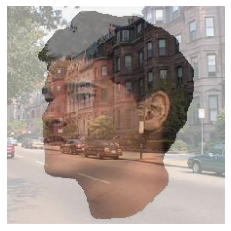

In [10]:
# Merged images load
data_train = [[]  for i in range(8)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
#data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
#data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[4] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
#data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
#data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(8)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
#data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
#data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[4] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
#data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
#data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(8)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
#reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
#reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[4] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
#reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
#reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
#reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
#reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[4] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
#reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
#reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



# Model
Call the base model and the top model here

### Model Architecture

In [11]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet 
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


58892288/58889256 [==============================] - 1s 0us/step
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 18.600018978118896
Test Time: 1.2572784423828125
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total params: 102,772,738
Trainable params: 102,772,738
Non-trainable params: 0
_________________________________________________________________


### Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [12]:

acc = np.zeros((2,4))
for imtype in range(2):
  for cat in range(len(categories)):

    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 4])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
    print(train_it.shape,test_it.shape)

    
    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')
    
    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.24086856842041016
Test Time: 0.14042258262634277
Epoch 1/30
3/3 [==============================] - 1s 10ms/step - loss: 0.7328 - accuracy: 0.5633
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 0.4876 - accuracy: 0.9020
Epoch 3/30
3/3 [==============================] - 0s 10ms/step - loss: 0.3361 - accuracy: 0.8895
Epoch 4/30
3/3 [==============================] - 0s 9ms/step - loss: 0.2641 - accuracy: 0.9102
Epoch 5/30
3/3 [==============================] - 0s 9ms/step - loss: 0.2190 - accuracy: 0.9035
Epoch 6/30
3/3 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.9332
Epoch 7/30
3/3 [==============================] - 0s 9ms/step - loss: 0.1641 - accuracy: 0.9387
Epoch 8/30
3/3 [==============================] - 0s 10ms/step - loss: 0.1424 - accuracy: 0.9590
Epoch 9/30
3/3 [==============================] - 0s 10ms/step - loss: 0.1287 - accuracy: 0.9668
Epo

### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

0.8312500044703484


Text(0, 0.5, 'Δ Accuracy')

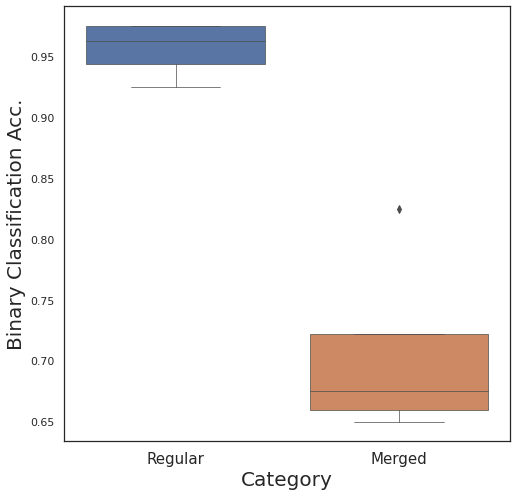

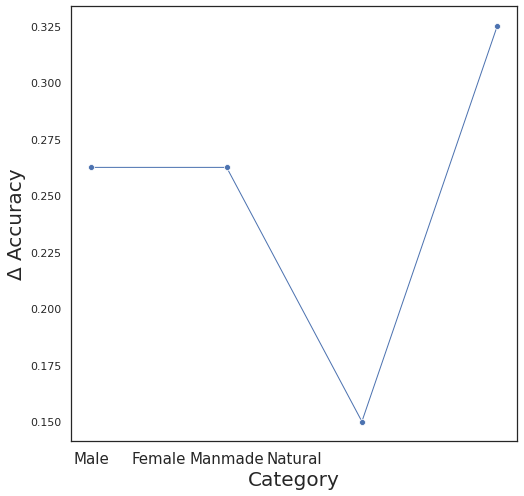

In [14]:
diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns

sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (8,8))
ax = sns.boxplot(data = acc.T )
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 15)
ax.set_ylabel('Binary Classification Acc.',size = 20)

# Cateogory wise performance difference
plt.figure(figsize = (8,8))
sns.set(style="white",rc={"lines.linewidth": 1})
ax = sns.lineplot(data = diff ,marker="o")
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Male','Female','Manmade','Natural'],size = 15)
ax.set_ylabel('\u0394 Accuracy',size = 20)



# Tuning Value Calculation

In [15]:
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(6): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



Category of interest:  Male
Elapsed: 14.070783615112305s
Category of interest:  Female
Elapsed: 13.868592023849487s
Category of interest:  Manmade
Elapsed: 13.9542236328125s
Category of interest:  Natural
Elapsed: 14.123635292053223s


IndexError: ignored

### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(len(categories)): 
  with open ('/content/drive/My Drive/obj/tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



240

### Calculation of tuning values for each map

In [ ]:
ncats = len(categories)
# to fish out each category tun_activations
labels = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 40 + [5] * 40)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]

### Tuning quality

(0.0, 50.0)

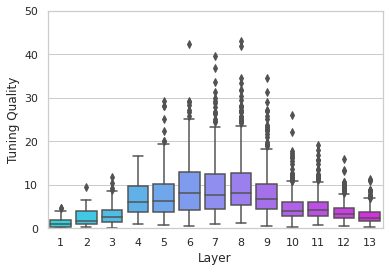

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

### Tuning quality for face images

Text(0.5, 1.0, 'Tuning quality for Face Images')

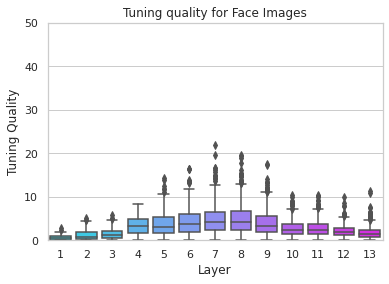

In [ ]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < abs(fc[cat][layer][map]):
        tun_q_face[layer][map] = abs(fc[cat][layer][map])

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])
plt.title('Tuning quality for Face Images')


### Tuning quality for non face neurons

Text(0.5, 1.0, 'Tuning quality for Tool Images')

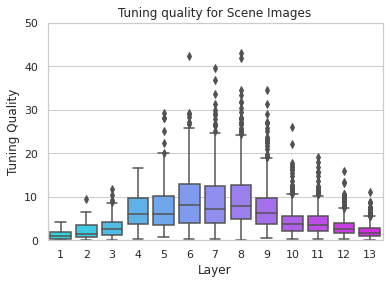

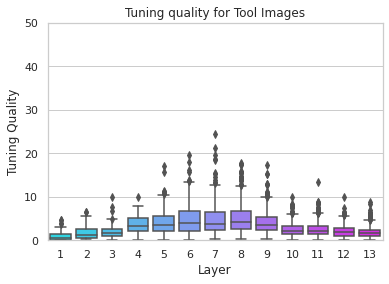

In [ ]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2,4):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < abs(fc[cat][layer][map]):
        tun_q_face[layer][map] = abs(fc[cat][layer][map])

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])
plt.title('Tuning quality for Scene Images')

plt.figure()

tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(4,6):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < abs(fc[cat][layer][map]):
        tun_q_face[layer][map] = abs(fc[cat][layer][map])

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])
plt.title('Tuning quality for Tool Images')


Text(0.5, 1.0, 'Number of face selective neurons')

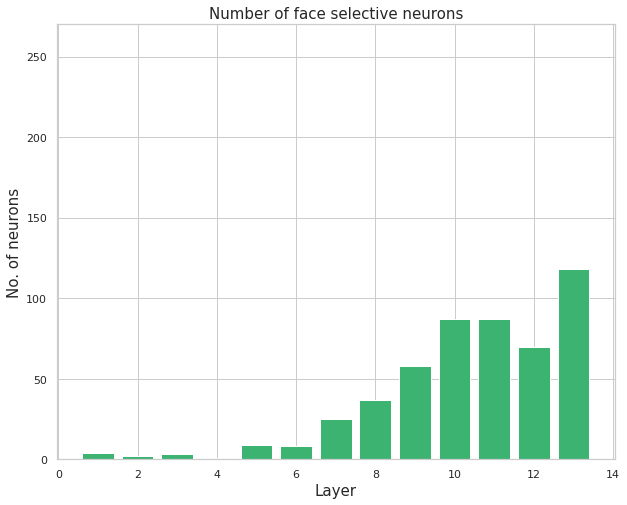

In [ ]:
idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(6):
      if abs(fc[cat][layer][map]) > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

counter = np.zeros(13)
fig = plt.figure(figsize = (10,8))
for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      counter[layer] += 1
plt.bar(x = np.arange(1,14,1),
        height = counter,
        color = 'mediumseagreen')
plt.ylim(0,270)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of neurons',size = 15)
plt.title('Number of face selective neurons',size = 15)

Text(0.5, 1.0, 'Number of selective neurons, category wise')

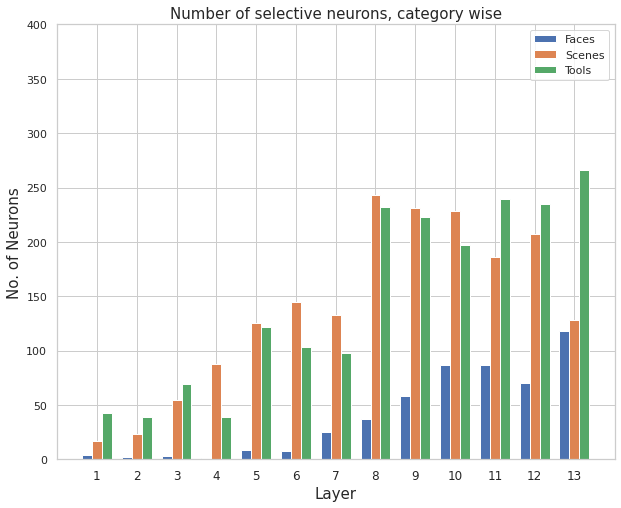

In [ ]:
width = 0.25

idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(6):
      if abs(fc[cat][layer][map]) > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)
c_tool = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1
    elif ele == 4 or ele ==5:
      c_tool[layer] += 1


fig, ax = plt.subplots(figsize = (10,8))
rects1 = ax.bar(np.arange(13) - width , c_face, width, label='Faces')
rects2 = ax.bar(np.arange(13) , c_scene, width, label='Scenes')
rects3 = ax.bar(np.arange(13) + width, c_tool, width, label='Tools')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend()

plt.ylim(0,400)
plt.xticks(np.arange(13),np.arange(1,14),size = 12)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of Neurons',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)

In [ ]:
str(np.arange(1,14))

'[ 1  2  3  4  5  6  7  8  9 10 11 12 13]'